# Semi-supervised Node Classification on Molecular Structures
## Node prediction

## Model Definition

In [29]:
import json
import os

import dgl
import dgl.nn as gnn
import hydra
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py3Dmol
import pymatgen.core as mg
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython import display
from ipywidgets import Button, Dropdown, HBox, VBox
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score)
from torch import nn
from torchviz import make_dot
from tqdm.notebook import tqdm

from src.lib.lib_trainer import PLEGATNodePredictor
from matgl.layers._basis import GaussianExpansion

hydra.initialize(config_path="src/config")
cfg = hydra.compose(config_name='train', overrides=[], return_hydra_config=True)

os.environ.setdefault('DGLBACKEND','pytorch')

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

/tmp/ipykernel_2582983/2227970265.py:29: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="src/config")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:29                                                                                   │
│                                                                                                  │
│   26 from src.lib.lib_trainer import PLEGATNodePredictor                                         │
│   27 from matgl.layers._basis import GaussianExpansion                                           │
│   28                                                                                             │
│ ❱ 29 hydra.initialize(config_path="src/config")                                                  │
│   30 cfg = hydra.compose(config_name='train', overrides=[], return_hydra_config=True)            │
│   31                                                                                             │
│   32 os.environ.setdefault('DGLBACKEND','pytorch')                                               │
│                                                                                                  │
│ /home/tomcort/.conda/envs/graphenenv/lib/python3.10/site-packages/hydra/initialize.py:91 in      │
│ __init__                                                                                         │
│                                                                                                  │
│    88 │   │   │   │   calling_file=calling_file, calling_module=calling_module                   │
│    89 │   │   │   )                                                                              │
│    90 │   │                                                                                      │
│ ❱  91 │   │   Hydra.create_main_hydra_file_or_module(                                            │
│    92 │   │   │   calling_file=calling_file,                                                     │
│    93 │   │   │   calling_module=calling_module,                                                 │
│    94 │   │   │   config_path=config_path,                                                       │
│                                                                                                  │
│ /home/tomcort/.conda/envs/graphenenv/lib/python3.10/site-packages/hydra/_internal/hydra.py:53 in │
│ create_main_hydra_file_or_module                                                                 │
│                                                                                                  │
│    50 │   │   │   calling_file, calling_module, config_path                                      │
│    51 │   │   )                                                                                  │
│    52 │   │                                                                                      │
│ ❱  53 │   │   return Hydra.create_main_hydra2(job_name, config_search_path)                      │
│    54 │                                                                                          │
│    55 │   @classmethod                                                                           │
│    56 │   def create_main_hydra2(                                                                │
│                                                                                                  │
│ /home/tomcort/.conda/envs/graphenenv/lib/python3.10/site-packages/hydra/_internal/hydra.py:68 in │
│ create_main_hydra2                                                                               │
│                                                                                                  │
│    65 │   │   hydra = cls(task_name=task_name, config_loader=config_loader)                      │
│    66 │   │   from hydra.core.global_hydra import GlobalHydra                                    │
│    67 │   │                                                                                      │
│ ❱  68 │   │   GlobalHydra.instance().initialize(hydra)     

### EGAT

In [9]:
model = PLEGATNodePredictor(cfg)
print(model)
tot = 0
for name, param in model.named_parameters():
    print(name, param.shape,param.numel())
    tot += param.numel()
print('Total number of params:', tot)

PLEGATNodePredictor(
  (net): AllInOneEGAT(
    (gat): MyEGAT(
      (embedding): Embedding(95, 16)
      (convs): Sequential(
        (0): EGATConv(
          (fc_node_src): Linear(in_features=16, out_features=128, bias=False)
          (fc_ni): Linear(in_features=16, out_features=512, bias=False)
          (fc_nj): Linear(in_features=16, out_features=512, bias=False)
          (fc_fij): Linear(in_features=100, out_features=512, bias=False)
        )
        (1): EGATConv(
          (fc_node_src): Linear(in_features=128, out_features=256, bias=False)
          (fc_ni): Linear(in_features=128, out_features=512, bias=False)
          (fc_nj): Linear(in_features=128, out_features=512, bias=False)
          (fc_fij): Linear(in_features=512, out_features=512, bias=False)
        )
      )
    )
    (node_s2s): Set2Set(
      n_iters=2
      (lstm): LSTM(512, 256)
    )
    (edge_s2s): EdgeSet2Set(
      (lstm): LSTM(1024, 512, num_layers=2)
    )
    (regressor): GatedMLP(
      (layers): 

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs):
        super(MyDataset).__init__()
        self.graphs = graphs
        
    def __getitem__(self,idx):
        return self.graphs[idx]
    
    def __len__(self):
        return len(self.graphs)
    
def mask_labels(labels, sample_frac=0.2):
    mask = torch.rand(len(labels),device=labels.device) < sample_frac
    return labels * ~mask, mask

In [11]:
def get_cmap():
    df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")

    colors = ['#000000']
    for i in range(1,95):
        atom = mg.Element.from_Z(i).name
        r = df_colors[df_colors['atom'] == atom]['R'].values[0]
        g = df_colors[df_colors['atom'] == atom]['G'].values[0]
        b = df_colors[df_colors['atom'] == atom]['B'].values[0]
        colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))

    cmap = LinearSegmentedColormap.from_list('Atoms',colors)
    return colors, cmap

colors, cmap = get_cmap()

def plot_graph(g,attention=None,title='',ax=None, mask = None, predictions = None):

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax  = fig.add_subplot(projection='3d',title=title)
    else: ax.set_title(title)
    positions = g.ndata['pos']
    atomic_numbers = g.ndata['node_type']
    edges_src,edges_dst= g.edges()

    scatter = ax.scatter(positions[:,0],positions[:,1],positions[:,2],s=atomic_numbers*10,c=atomic_numbers,cmap = cmap, vmin=0, vmax=len(colors))
    ax.view_init(azim=0, elev=90)
    ax.grid(False)
    if mask is not None: 
        ax.scatter(positions[mask,0],positions[mask,1],positions[mask,2],
                   s=atomic_numbers[mask]*15,
                   facecolors='none', 
                   edgecolors='gray',
                   linewidths=3.0,
                   alpha=0.5)
        if predictions is not None: 
            right = (atomic_numbers == predictions)
            wrong = mask & ~right 
            right = mask & right 
            

            ax.scatter(positions[right,0],positions[right,1],positions[right,2],s=atomic_numbers[right]*20,facecolors='none', edgecolors='green',linewidths=3.0)
            ax.scatter(positions[wrong,0],positions[wrong,1],positions[wrong,2],s=atomic_numbers[wrong]*20,facecolors='none', edgecolors='red',linewidths=3.0)

    a = scatter.legend_elements()
    legend1 = ax.legend(a[0],[mg.Element.from_Z(int(s[14:-2])).name for s in a[1]],loc="lower left", title="Element Types")
    ax.add_artist(legend1)
    for i,(src,dst) in enumerate(zip(edges_src,edges_dst)):
        sx ,sy, sz = positions[src]
        dx ,dy, dz = positions[dst]
        lx,ly,lz =np.linspace(sx,dx,10),np.linspace(sy,dy,10),np.linspace(sz,dz,10)
        ax.plot(lx,ly,lz, c='black', alpha = 0.5 if attention is None else attention[i])
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('c')
    return ax


def graph2xyz(graph):
    return f"{graph.num_nodes()}\n\n"+\
            "\n".join([f"{mg.Element.from_Z(graph.ndata['node_type'][i]).name} {graph.ndata['pos'][i][0]} {graph.ndata['pos'][i][1]} {graph.ndata['pos'][i][2]}" 
                       for i in range(graph.num_nodes())])

def getView(graph):
    #First we assign the py3Dmol.view as view
    view=py3Dmol.view()
    #The following lines are used to add the addModel class
    #to read the PDB files of chain B and C
    view.addModel(graph2xyz(graph),'xyz',{'bondLength':0.5})

    #Here we set the background color as white
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    # view.setStyle({'chain':'A'},{"stick": {'color': 'black'}})
    view.setStyle({'stick': {'opacity':0.6 , 'radius':0.05,'color':'black'}})

    for i in range(graph.num_nodes()):
        atom_line = 'H {:f} {:f} {:f}\n'.format( *graph.ndata['pos'][i])
        atom_model = '1\n\n' + atom_line
        view.addModel(atom_model, 'xyz')
        # color = get_color_based_on_atom_type(graph.ndata['node_type'][i],0,7)
        node_type = graph.ndata['node_type'][i].item()
        # color = get_color(mg.Element.from_Z(node_type).name)
        color = colors[node_type]

        view.setStyle({'model': -1}, 
                      {'sphere': {'color': color, 'radius':node_type/40}},)

    #Zooming into all visualized structures 
    view.zoomTo()

    return view

In [12]:
def compute_attentions(model,g,nfeats,efeats):
    attentions = []
    nfeats = model.gat.embedding(nfeats)
    for layer in model.gat.convs: 
        nfeats,efeats,attn = layer(g,nfeats,efeats,get_attention=True)#.view(g.num_nodes(),-1)    
        nfeats = model.gat.activation(nfeats.view(g.num_nodes(),-1))
        efeats = model.gat.activation(efeats.view(g.num_edges(),-1))    
        attentions.append(attn)

    out_feats,_,attn = model.classifier(g,nfeats,efeats,get_attention=True)
    out_feats = out_feats.mean(dim=1)
    attentions.append(attn)
    return F.softmax(out_feats,dim=1),attentions


def display_selector(g,attns,name='',mask=None,predictions=None):

    is_matplotlib_inline = matplotlib.get_backend()=="module://matplotlib_inline.backend_inline"
    # Create the list of plots
    plots = []
    plot_idx = 0

    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            plots.append((f'att{i}_{j}',att))

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111,projection='3d')

    # Create the dropdown widget and buttons
    dropdown_plot_selector = Dropdown(options=[plot[0] for plot in plots])
    prevButton = Button(description="<")
    nextButton = Button(description=">")
    # Display them
    box = HBox([prevButton,dropdown_plot_selector,nextButton])
    display.display(box)

    # Workaround to dinamically show plots when inline
    if is_matplotlib_inline:
        hdisplay_img = display.display(display_id=True)
        plt.close()

    def plot_selector(change):
        nonlocal plot_idx,prevButton,nextButton
        selected_plot = dropdown_plot_selector.value
        for i,(title,att) in enumerate(plots):
            if title == selected_plot: 
                ax.clear()
                if name: title = name +" - " + title
                plot_graph(g.cpu(),attention=att.numpy(),title=title,mask=mask, predictions=predictions,ax=ax)
                plot_idx = i
                if is_matplotlib_inline:
                    hdisplay_img.update(fig)
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1

    def swipe(backward = False):
        nonlocal plot_idx,prevButton,nextButton
        if not backward: 
            if 0 < len(plots)-1:
                 plot_idx += 1
        elif plot_idx > 0: 
            plot_idx -= 1
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1
        dropdown_plot_selector.value = plots[plot_idx][0]
        dropdown_plot_selector.selected_label = plots[plot_idx][0]
        plot_selector(None)

    dropdown_plot_selector.observe(plot_selector, names='value')
    prevButton.on_click(lambda x : swipe(backward = True))
    nextButton.on_click(lambda x : swipe(backward = False))
    prevButton.disabled = True


    plot_selector(None)
    return

def display_attn_grid(g,attns,prefix = None, mask = None,preds = None):
    fig,axs = plt.subplots(3,8,subplot_kw={'projection':'3d'})
    fig.set_size_inches(25,12)
    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            if prefix is not None: title = f'{prefix} - att{i}_{j}'
            else: title = f'att{i}_{j}'
            plot_graph(g,attention=att.numpy(),title=title,mask = mask, predictions = preds,ax=axs[i,j])
            
            axs[i,j].get_legend().set_visible(False)
    lines = axs[0,0].get_legend().get_lines()
    texts = [e.get_text() for e in axs[0,0].get_legend().get_texts()]
    fig.legend(lines,texts,loc='upper center', ncol=8)
    plt.tight_layout()
    plt.show()

def accuracy_report(labels,preds):
    print("accuracy:",accuracy_score(labels,preds))

    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    print("f1_score:")
    for i, label in enumerate(labels_unique):
        print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
    print("\tavg(macro):", f1_score(labels,preds,average='macro'))
    print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
    print()
    print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
    print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
    return

def plot_confusion_matrix(labels,preds,label_mappings=None,figsize=None,normalize = None):
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    if label_mappings is not None:
        lab = list(label_mappings.keys())
        lab_disp = list(label_mappings.values())
    else:
        lab,lab_disp = None,None
        
    include_values = len(label_mappings) < 30

    cm = confusion_matrix(labels,preds,labels=lab,normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lab_disp)
    disp.plot(include_values=include_values,ax=ax)
    plt.show()

In [13]:
INTERACTIVE = False

## MP

In [14]:
with open('/home/tomcort/data/MP_ref_supercell_splits.json') as f:
    splits = json.load(f)
    
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/MP_ref_supercell_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)
graphs_ids = target_dict['graphs_ids'][splits['test']]
model_MP = PLEGATNodePredictor.load_from_checkpoint('/home/tomcort/MaMoMo/models/2-MP/model.ckpt')

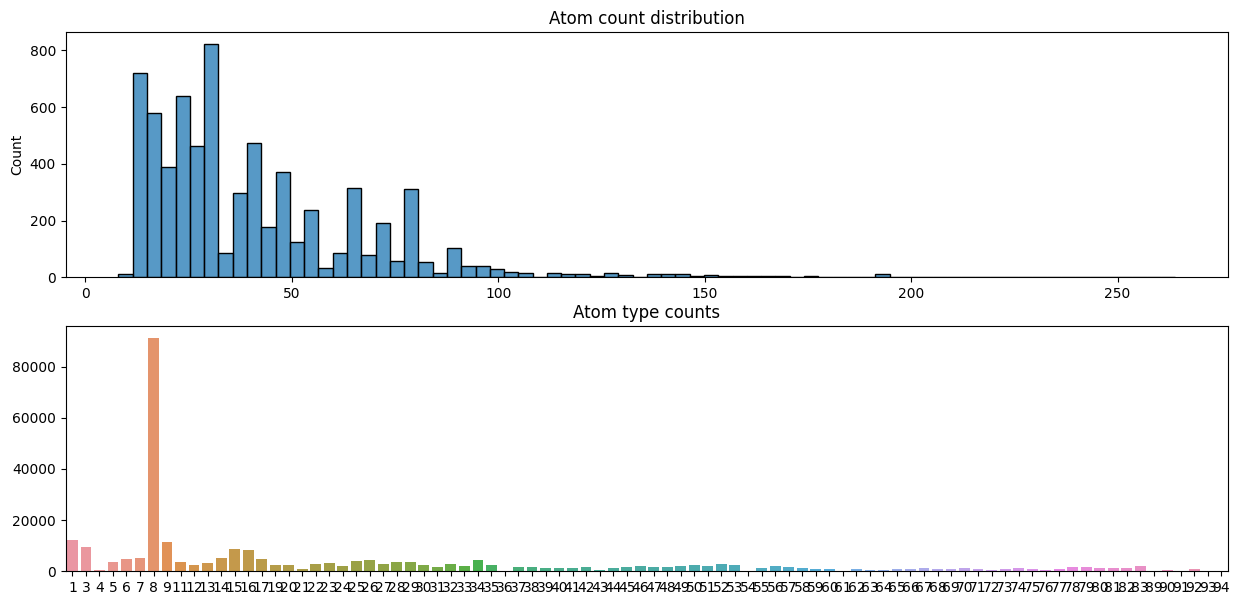

In [15]:
node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
num_nodes = np.array([g.num_nodes() for g in graphs])
unique_node_types,counts = np.unique(node_types,return_counts=True)

fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(15,7)
ax1.title.set_text('Atom count distribution')
sns.histplot(num_nodes,ax=ax1)
ax2.title.set_text('Atom type counts')
sns.barplot(x=unique_node_types,y=counts,ax=ax2)
plt.show()

In [19]:
model = model_MP.to(device)
preds = []
labels = []
transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        g= g.to(device)
        efeats = g.edata['bond_dist_exp'].to(device)
        node_types = g.ndata['node_type'].to(device)
        nfeats,mask = mask_labels(node_types)

        logits,attns = compute_attentions(model.net,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/231 [00:00<?, ?it/s]

accuracy: 0.9649688259537145
f1_score:
	H: 0.9864587607714402
	Li: 0.9538866930171278
	Be: 0.9596774193548387
	B: 0.973718791064389
	C: 0.9545691906005223
	N: 0.9174887892376681
	O: 0.9945292096219932
	F: 0.9812699862951119
	Na: 0.9465875370919881
	Mg: 0.9044943820224719
	Al: 0.9381818181818182
	Si: 0.9705456301303718
	P: 0.9806190338443739
	S: 0.9751273599041055
	Cl: 0.9686825053995681
	K: 0.9497536945812808
	Ca: 0.9410503751339764
	Sc: 0.9593023255813954
	Ti: 0.9456625357483317
	V: 0.9399830938292477
	Cr: 0.9067599067599067
	Mn: 0.9151898734177215
	Fe: 0.9355608591885441
	Co: 0.9177570093457944
	Ni: 0.946629213483146
	Cu: 0.9192307692307691
	Zn: 0.9239881539980257
	Ga: 0.9373040752351097
	Ge: 0.936663693131133
	As: 0.932484076433121
	Se: 0.9664582148948266
	Br: 0.9569202566452795
	Kr: 1.0
	Rb: 0.9484240687679083
	Sr: 0.959349593495935
	Y: 0.9498997995991985
	Zr: 0.9642184557438794
	Nb: 0.9328063241106719
	Mo: 0.9148099606815203
	Tc: 0.955223880597015
	Ru: 0.9326424870466321
	Rh: 0.97

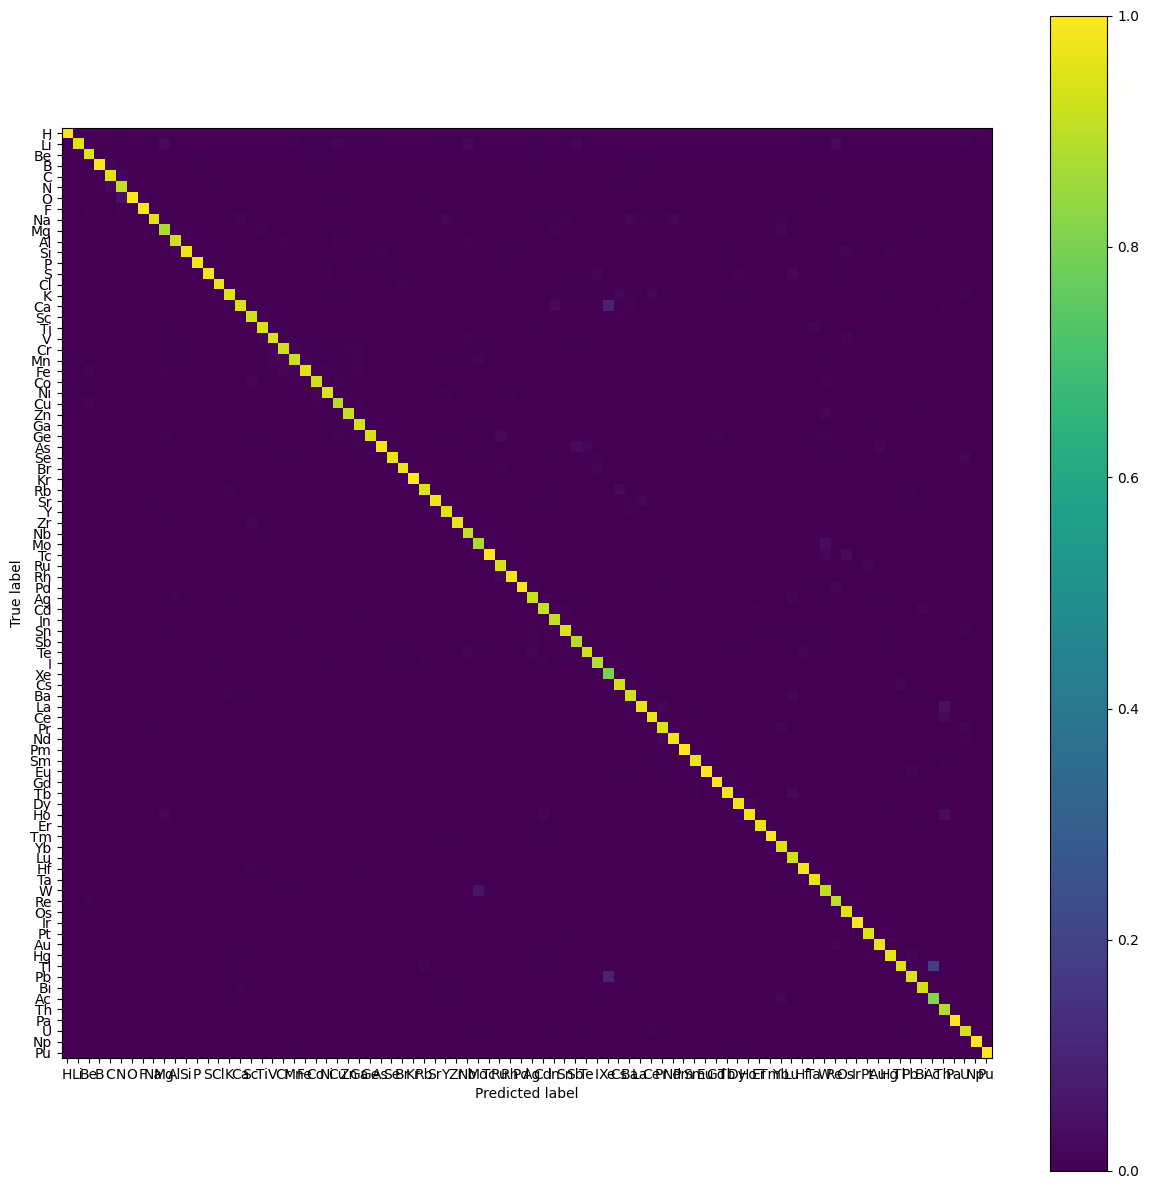

In [20]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(15,15),normalize='pred' )

In [21]:
idx = np.random.randint(len(graphs))
g = graphs[idx]
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

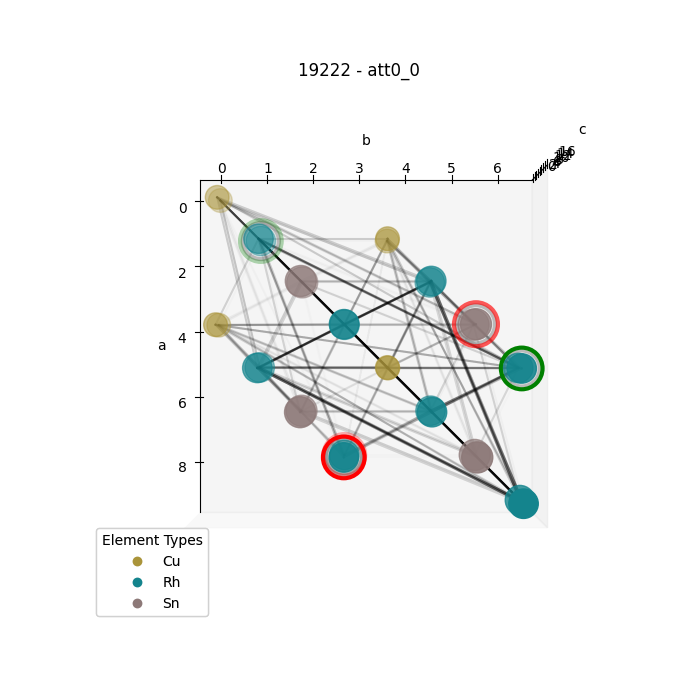

In [28]:
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = transform(g.edata['bond_dist'])
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

if True:
    display_selector(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))

In [27]:
mask

tensor([False, False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
         True, False])

In [13]:
del graphs, dataset, target_dict

## QM9

In [14]:
with open('/home/tomcort/data/QM9_splits.json') as f:
    splits = json.load(f)
    
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/QM9_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)

model_QM9 = PLEGATNodePredictor.load_from_checkpoint('/home/tomcort/MaMoMo/models/2-QM9/model.ckpt')
graphs_ids = target_dict['graphs_ids'][splits['test']]

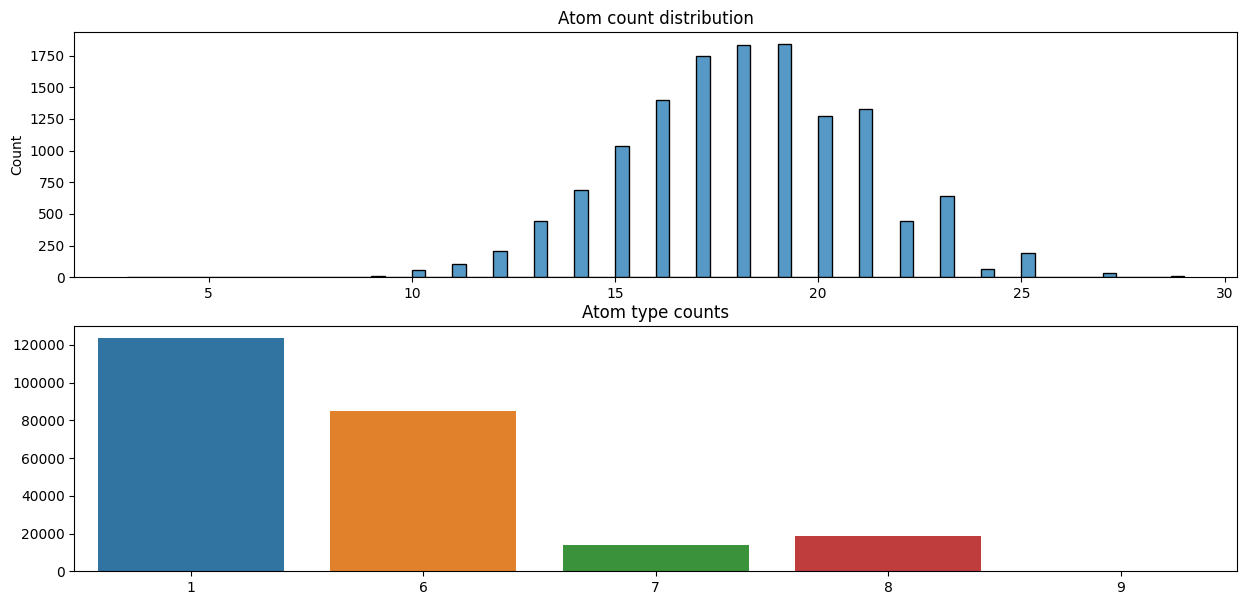

In [15]:
node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
num_nodes = np.array([g.num_nodes() for g in graphs])
unique_node_types,counts = np.unique(node_types,return_counts=True)

fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(15,7)
ax1.title.set_text('Atom count distribution')
sns.histplot(num_nodes,ax=ax1)
ax2.title.set_text('Atom type counts')
sns.barplot(x=unique_node_types,y=counts,ax=ax2)
plt.show()

In [16]:
model = model_QM9.to(device)
preds = []
labels = []

loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        g= g.to(device) 
        efeats = g.edata['bond_dist_exp'].to(device)
        node_types = g.ndata['node_type'].to(device) 
        nfeats,mask = mask_labels(node_types)


        logits,attns = compute_attentions(model.net,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/447 [00:00<?, ?it/s]

accuracy: 0.9997704603313718
f1_score:
	H: 1.0
	C: 0.9998212263869852
	N: 0.9980304386750224
	O: 0.9993330665599574
	F: 1.0
	avg(macro): 0.999436946324393
	avg(weighted): 0.9997705112912996

Labels counts: H:24528,  C:16782,  N:2791,  O:3749,  F:72
Prediction counts: H:24528,  C:16780,  N:2794,  O:3748,  F:72


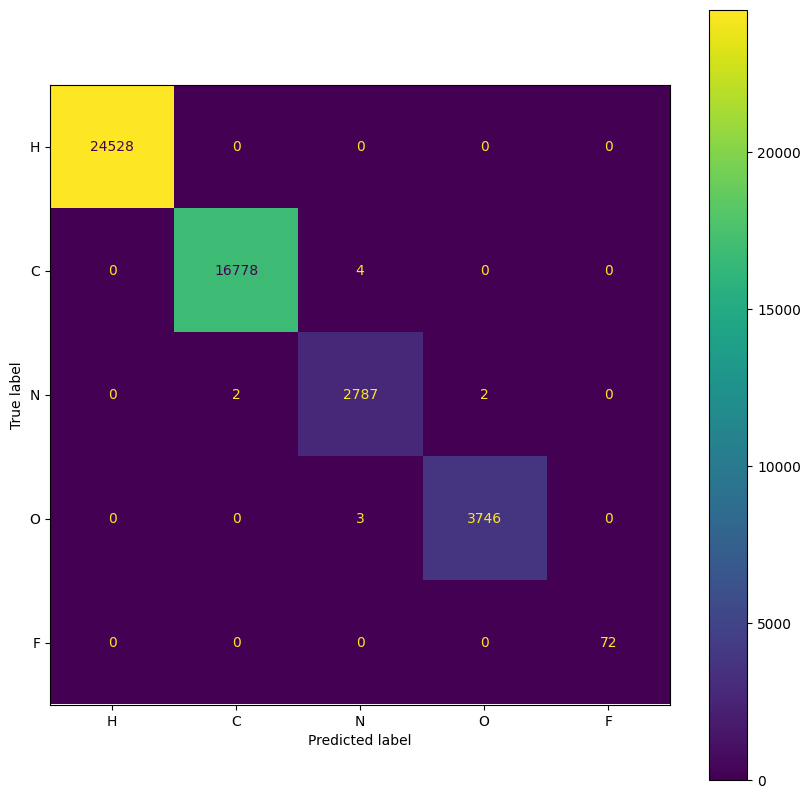

In [17]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(10,10),normalize = None)

In [18]:
idx = np.random.randint(len(graphs))
g = graphs[idx].to('cpu') 
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

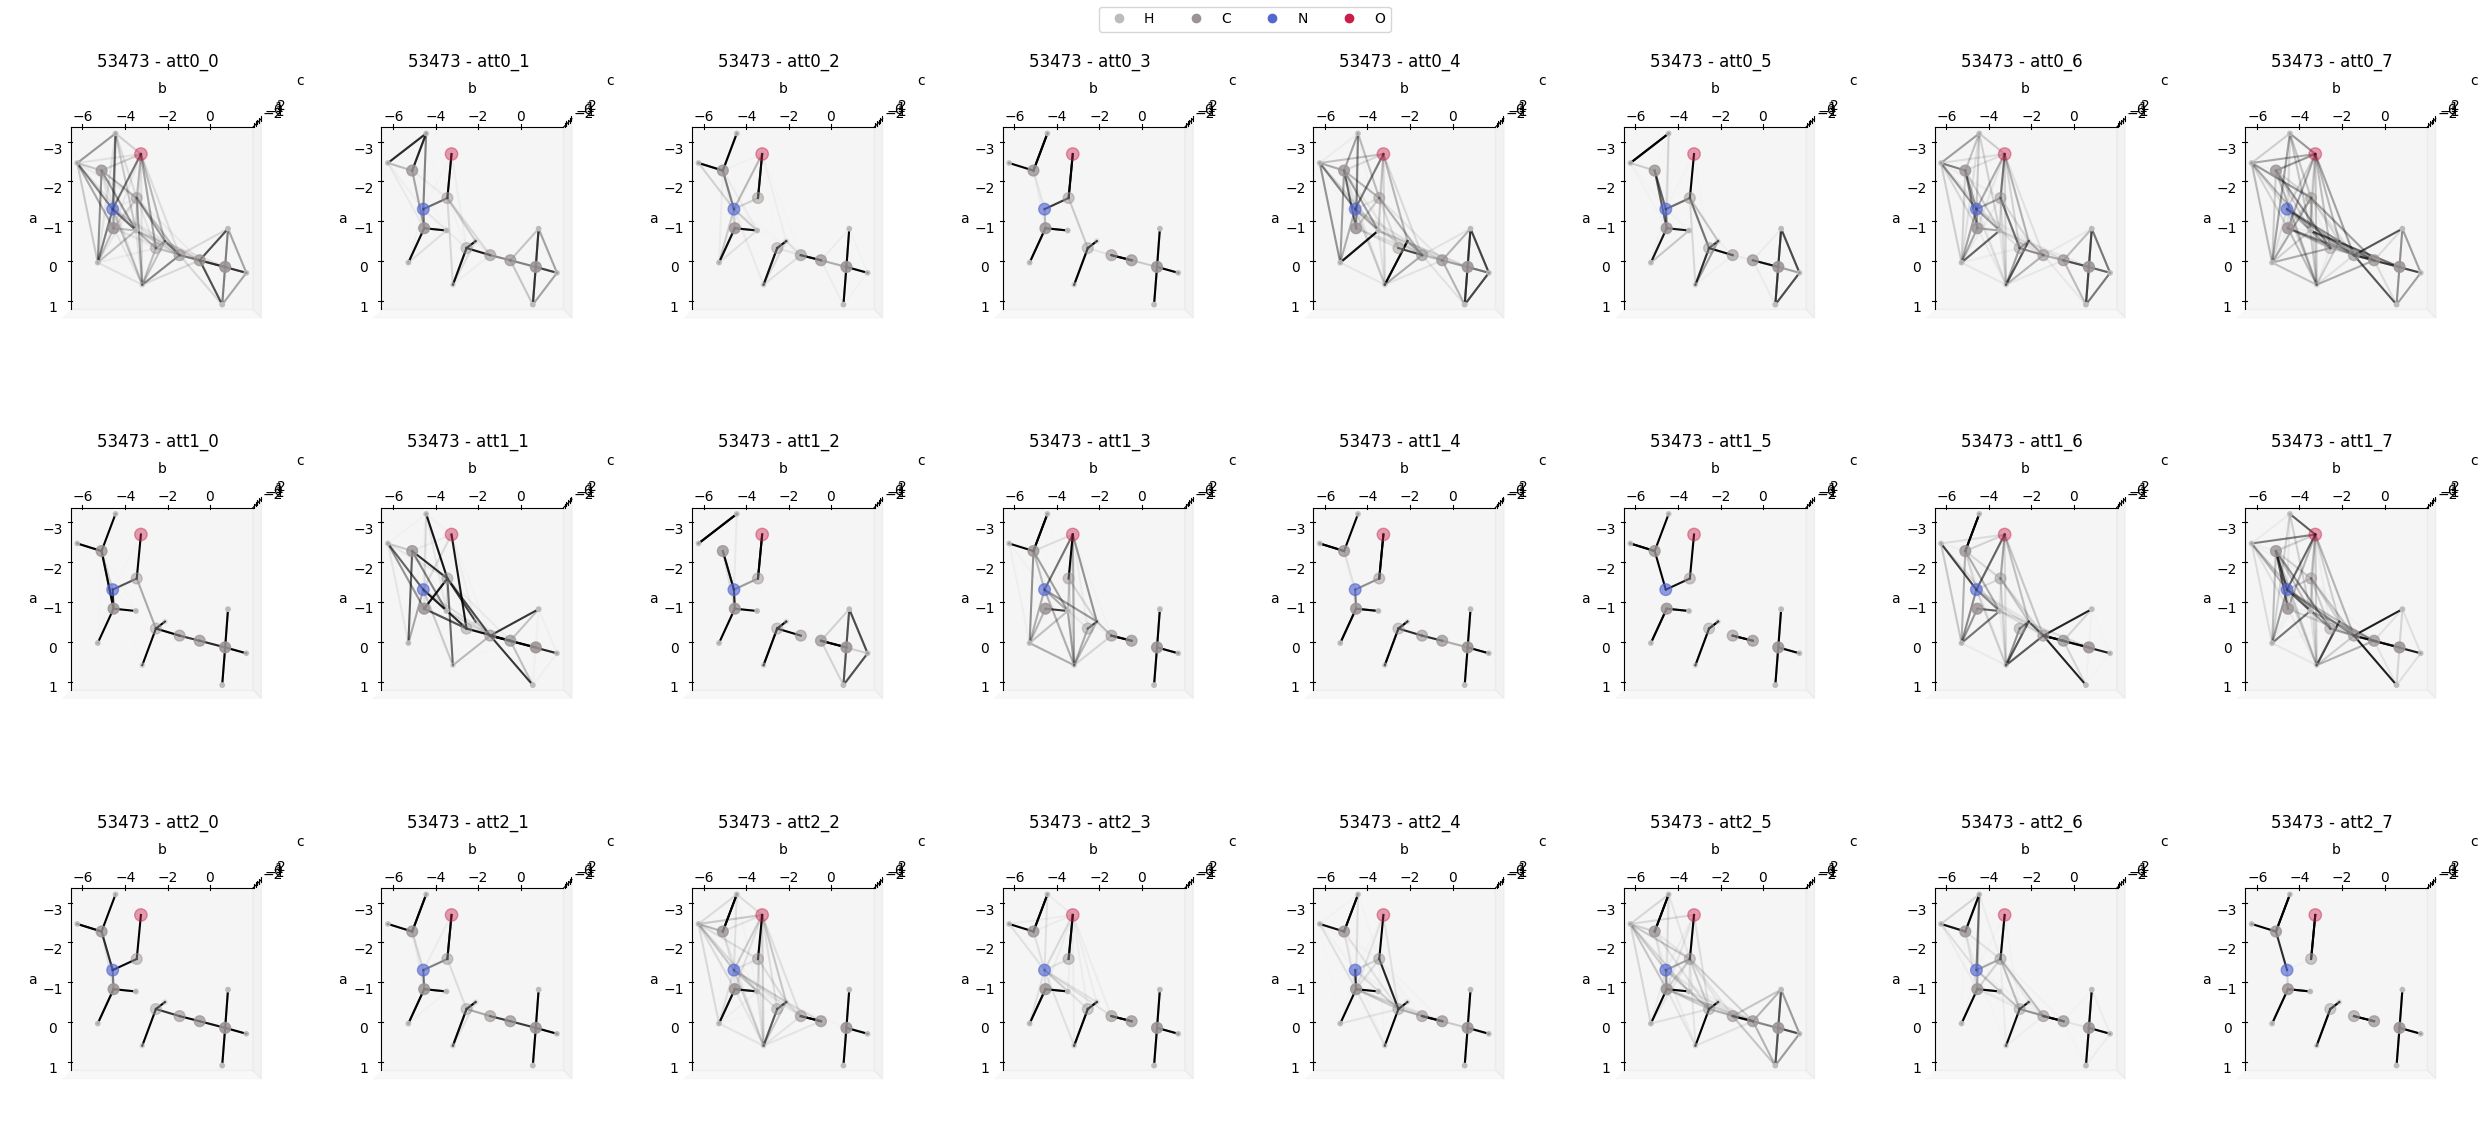

In [19]:
model = model_QM9.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = g.edata['bond_dist_exp'] 
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if INTERACTIVE: 
    display_selector(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))

In [20]:
del graphs, dataset, target_dict

## GO_ref

In [23]:
with open('/home/tomcort/data/GO_ref_splits.json') as f:
    splits = json.load(f)
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/GO_ref_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)

model_GO = PLEGATNodePredictor.load_from_checkpoint('/home/tomcort/MaMoMo/models/2-GO/model.ckpt')
graphs_ids = target_dict['graphs_ids'][splits['test']]

In [24]:
model = model_GO.to(device)
preds = []
labels = []

loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        g= g.to(device) 
        efeats = g.edata['bond_dist_exp'].to(device)
        node_types = g.ndata['node_type'].to(device) 
        nfeats,mask = mask_labels(node_types)


        logits,attns = compute_attentions(model.net,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/24 [00:00<?, ?it/s]

accuracy: 0.9999693151133295
f1_score:
	H: 1.0
	C: 0.9999773784658076
	O: 0.9999032476537556
	avg(macro): 0.999960208706521
	avg(weighted): 0.9999693139759818

Labels counts: H:15956,  C:66307,  O:15505
Prediction counts: H:15956,  C:66310,  O:15502


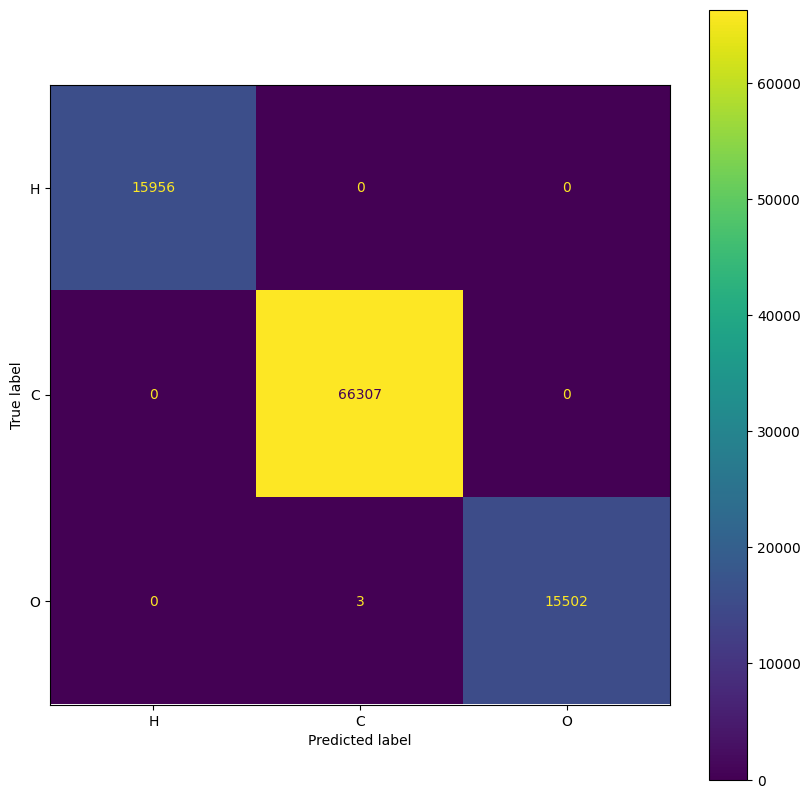

In [25]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(10,10),normalize = None)

In [26]:
idx = np.random.randint(len(graphs))
g = graphs[idx].to('cpu') 
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

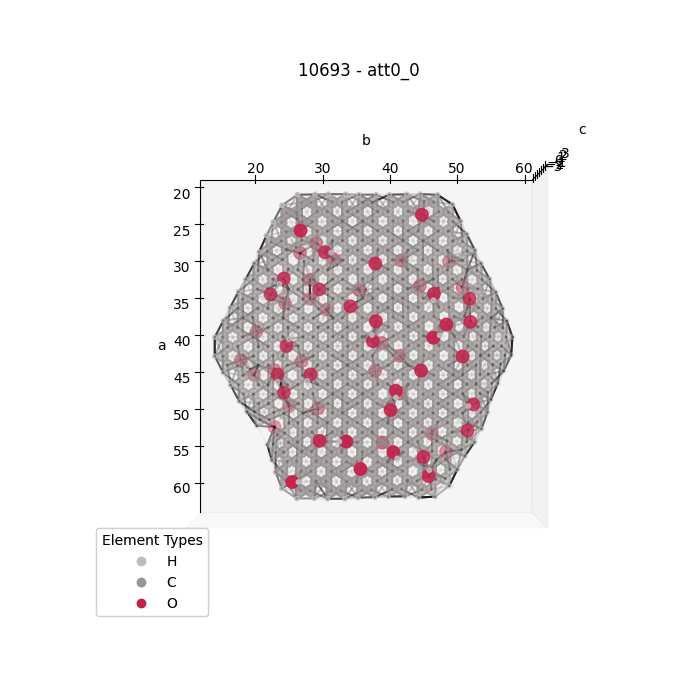

In [29]:
model = model_GO.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = g.edata['bond_dist_exp'] 
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if True: #full grid is too heavy to handle
    %matplotlib widget
    display_selector(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))
else:
    display_attn_grid(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))

## Joint Dataset

In [87]:
with open('/home/tomcort/data/joint_splits.json') as f:
    splits = json.load(f)
    
graphs,target_dict = dgl.load_graphs('/home/tomcort/data/joint_graphs.bin',idx_list=splits['test'])
dataset = MyDataset(graphs)
graphs_ids = target_dict['graphs_ids'][splits['test']]
model_joint = PLEGATNodePredictor.load_from_checkpoint('/home/tomcort/MaMoMo/models/2-Joint/model.ckpt')

In [40]:
node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
num_nodes = np.array([g.num_nodes() for g in graphs])
unique_node_types,counts = np.unique(node_types,return_counts=True)

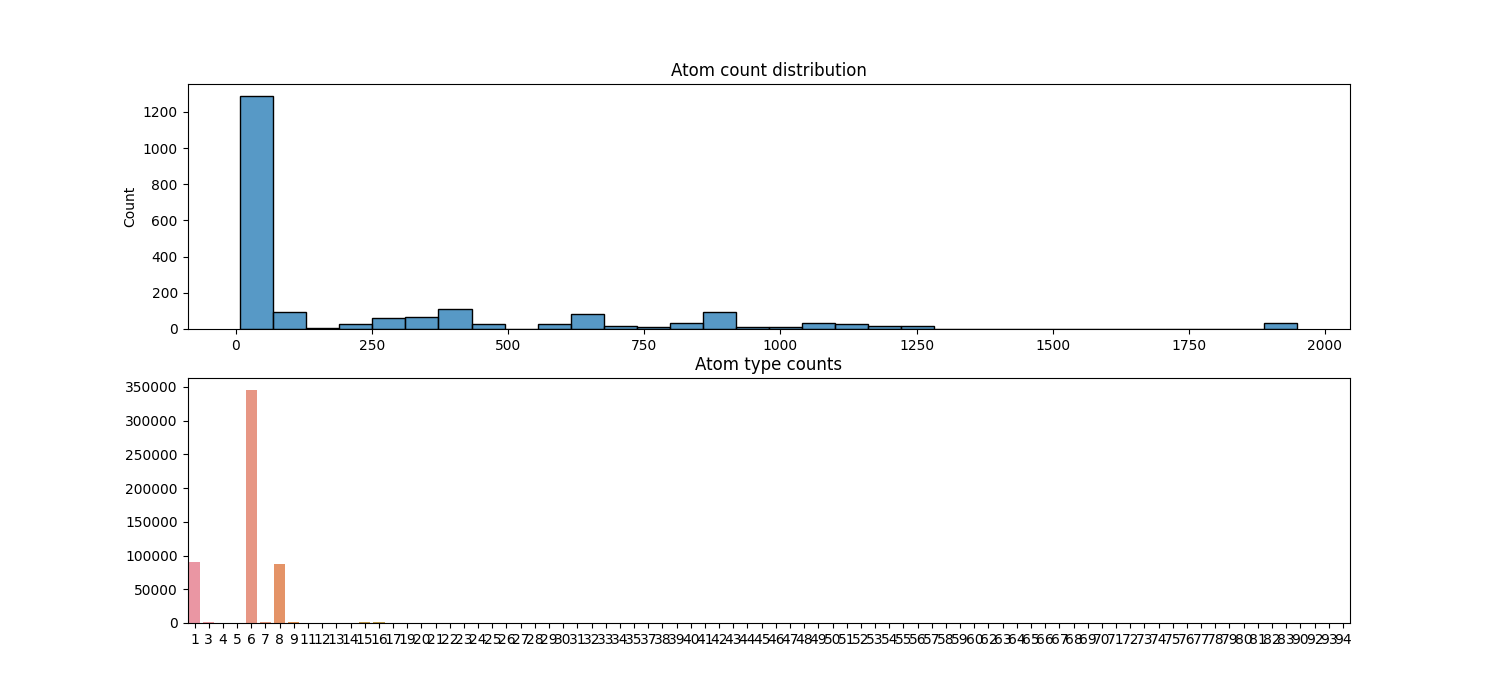

In [41]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(15,7)
ax1.title.set_text('Atom count distribution')
sns.histplot(num_nodes,ax=ax1)
ax2.title.set_text('Atom type counts')
sns.barplot(x=unique_node_types,y=counts,ax=ax2)
plt.show()

In [42]:
model = model_joint.to(device)
preds = []
labels = []
transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

In [43]:
loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        g= g.to(device)
        efeats = g.edata['bond_dist_exp'].to(device)
        node_types = g.ndata['node_type'].to(device)
        nfeats,mask = mask_labels(node_types)

        logits,attns = compute_attentions(model.net,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/70 [00:00<?, ?it/s]

accuracy: 0.9964410837593248
f1_score:
	H: 0.9997495199131669
	Li: 0.9396984924623115
	Be: 0.8571428571428571
	B: 0.96875
	C: 0.9995865760518738
	N: 0.8508771929824561
	O: 0.9978047042052743
	F: 0.964509394572025
	Na: 0.9069767441860465
	Mg: 0.8431372549019607
	Al: 0.9318181818181819
	Si: 0.9463414634146342
	P: 0.9702380952380952
	S: 0.9714285714285714
	Cl: 0.946808510638298
	K: 0.9183673469387755
	Ca: 0.9032258064516129
	Sc: 0.9600000000000001
	Ti: 0.8529411764705883
	V: 0.906474820143885
	Cr: 0.8547008547008546
	Mn: 0.9112426035502958
	Fe: 0.8544600938967137
	Co: 0.851063829787234
	Ni: 0.881118881118881
	Cu: 0.9440993788819876
	Zn: 0.8666666666666666
	Ga: 0.988235294117647
	Ge: 0.9555555555555556
	As: 0.8910891089108911
	Se: 0.9777777777777777
	Br: 0.9827586206896551
	Rb: 0.9494949494949494
	Sr: 0.888888888888889
	Y: 0.9473684210526315
	Zr: 0.9361702127659575
	Nb: 0.9393939393939394
	Mo: 0.9152542372881356
	Tc: 1.0
	Ru: 0.962962962962963
	Rh: 0.9696969696969697
	Pd: 0.974358974358974

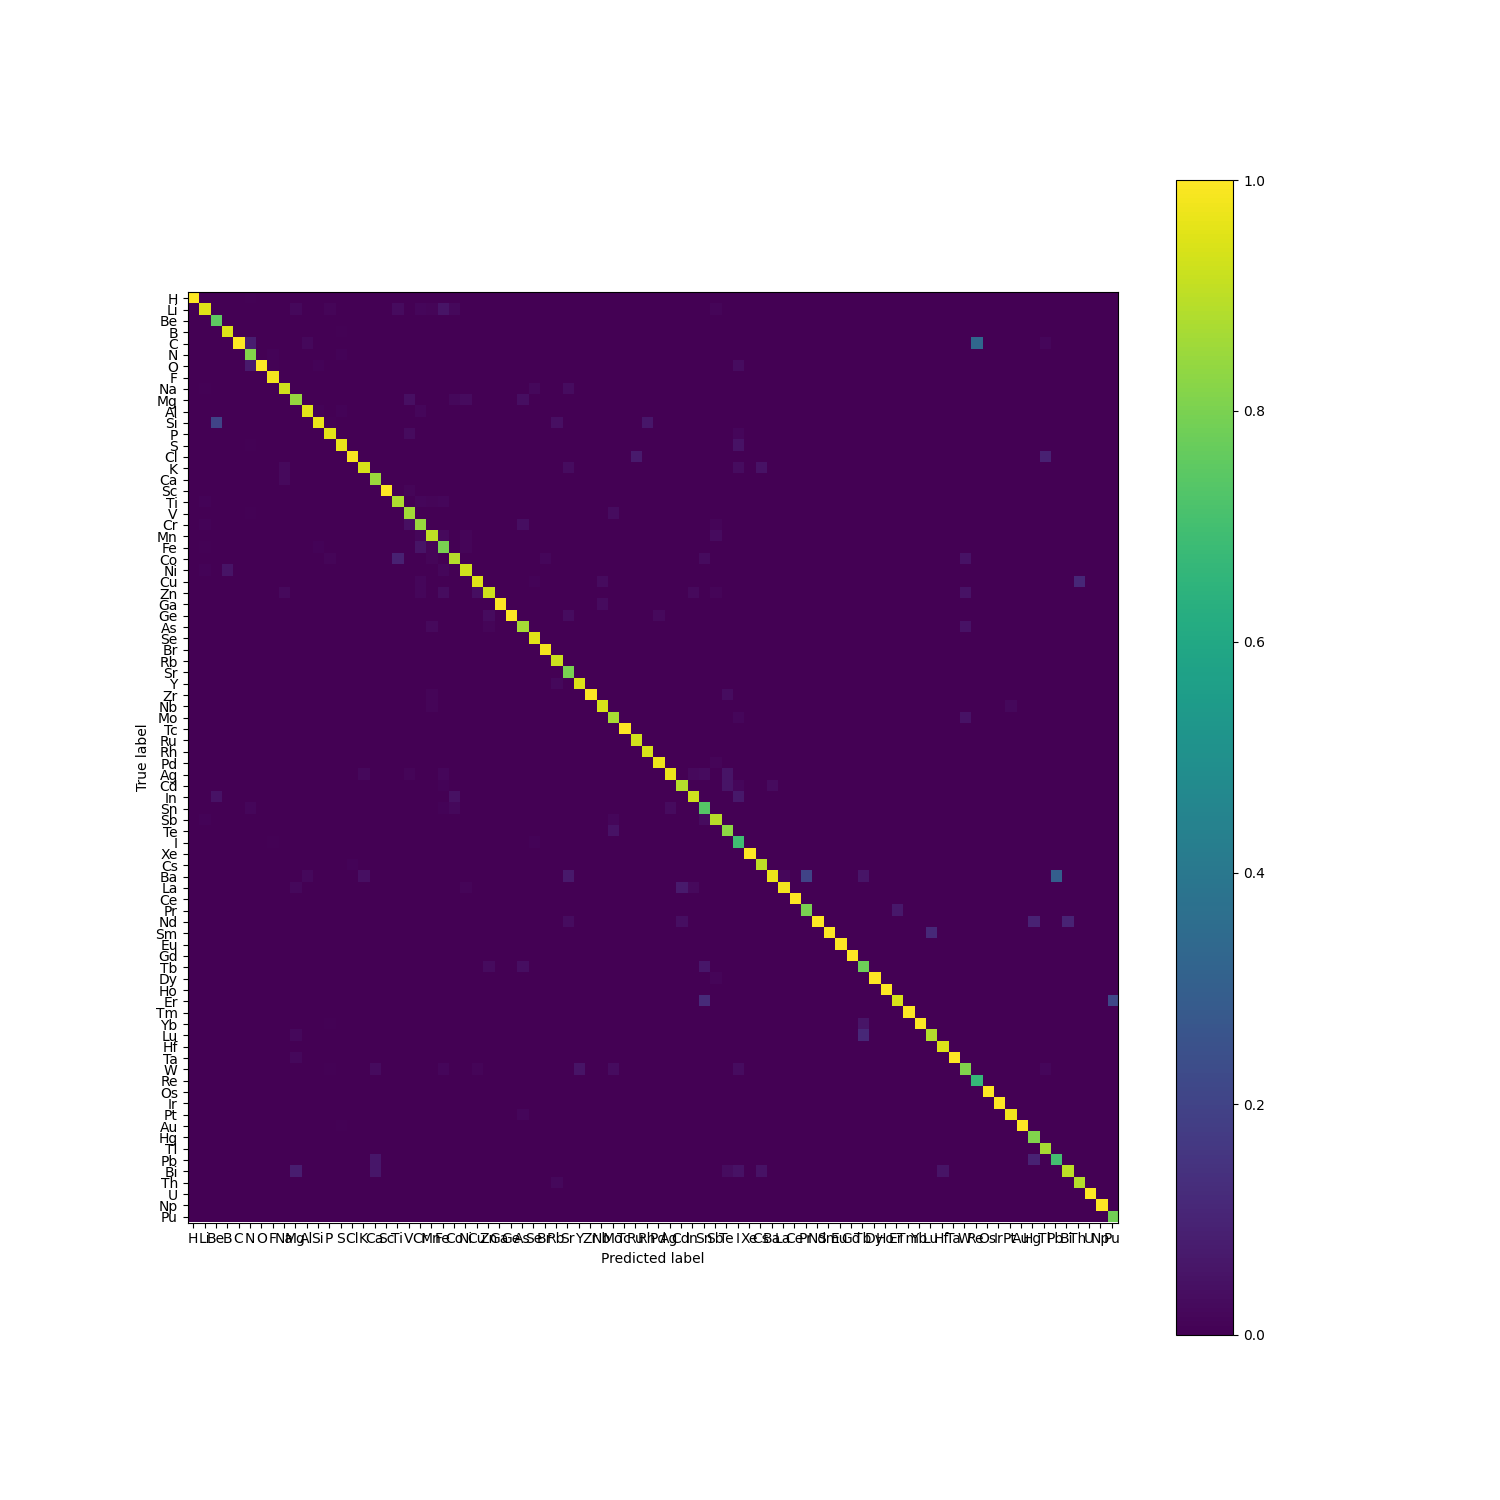

In [44]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(15,15),normalize='pred' )

In [46]:
idx = np.random.randint(len(graphs))
g = graphs[idx]
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

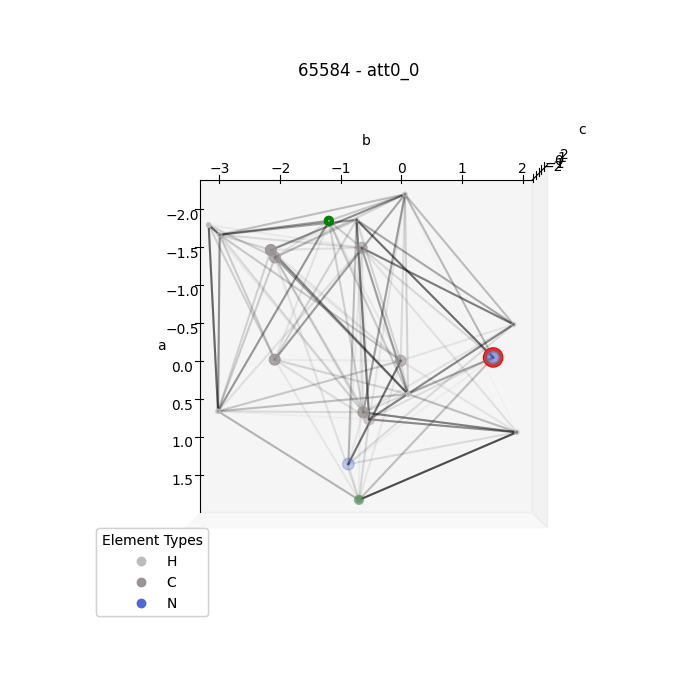

In [47]:
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = transform(g.edata['bond_dist'])
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)

if True:
    display_selector(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{graphs_ids[idx]}',mask,logits.argmax(dim=1))

In [49]:
del graphs, dataset, target_dict

## Try with random protein

In [48]:
with open('Hemoglobin.xyz','r') as f:
    lines = f.readlines()
lines

['4997\n',
 ' generated by VMD\n',
 ' N        10.720000       19.523001        6.163000\n',
 ' C        10.228000       20.761000        6.807000\n',
 ' C         8.705000       20.714001        6.878000\n',
 ' O         8.164000       20.004999        6.015000\n',
 ' C        10.602000       22.000000        5.966000\n',
 ' C        10.307000       23.296000        6.700000\n',
 ' C        12.065000       21.951000        5.544000\n',
 ' N         8.091000       21.452999        7.775000\n',
 ' C         6.624000       21.451000        7.763000\n',
 ' C         6.176000       22.577999        6.821000\n',
 ' O         6.567000       23.730000        7.022000\n',
 ' C         6.020000       21.707001        9.129000\n',
 ' C         6.386000       20.649000       10.198000\n',
 ' C         5.998000       21.118999       11.577000\n',
 ' C         5.730000       19.337000        9.795000\n',
 ' N         5.380000       22.237000        5.852000\n',
 ' C         4.831000       23.237000

In [51]:
import os
import torch
import pandas as pd
import glob
from scipy.spatial.distance import cdist
import pymatgen.core as mg
import dgl
from matgl.layers._basis import GaussianExpansion
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

os.environ.setdefault('DGLBACKEND ','pytorch')
def compute_bond_distances(coords,cutoff):
    _dist = cdist(coords,coords)
    src,dst = np.where(_dist <= cutoff)
    exclude_self = (src!=dst)
    src = src[exclude_self]
    dst = dst[exclude_self]
    dist = _dist[src,dst].flatten()

    return src,dst,dist

def load_structure(path,distance_cutoff,bond_expansion=False):
    transform = GaussianExpansion(initial=0,final=distance_cutoff+1,num_centers=100,width=0.5)
    with open (path,'r') as f:
        numel = int(f.readline())

        node_types = torch.empty(numel,dtype=torch.int32)
        coords = np.empty((numel,3),dtype=np.float32)

        lines = f.readlines()[1:numel+1]
        if numel != len(lines):
            raise Exception(f'Format of file {path} is broken')

        for i,line in enumerate(lines):
            line = line.replace('*^','e').split()
            line
            node_types[i] = torch.tensor(mg.Element(line[0]).number,dtype=torch.int32)
            coords[i]=np.array(line[1:4],dtype=np.float32)

        src,dst,bond_dists = compute_bond_distances(coords,distance_cutoff)

        coords = torch.tensor(coords)
        src = torch.from_numpy(src)
        dst = torch.from_numpy(dst)
        bond_dists = torch.from_numpy(bond_dists.astype(np.float32))


        graph = dgl.graph((src, dst), num_nodes=numel)
        graph.ndata['node_type'] = node_types
        graph.ndata['pos'] = coords
        graph.edata['bond_dist'] = bond_dists

        if bond_expansion:
            graph.edata['bond_dist_exp'] = transform(bond_dists)
        return graph

In [121]:
g = load_structure('Hemoglobin.xyz',4,True)
isolated_nodes = ((g.in_degrees() == 0) & (g.out_degrees() == 0)).nonzero().squeeze(1)
print(f"removing {len(isolated_nodes)} node(s)")
g.remove_nodes(isolated_nodes)

removing 1 node(s)


In [98]:
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [122]:
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = transform(g.edata['bond_dist'])
    logits,attns = compute_attentions(model.net,g,nfeats,efeats)
preds = logits.argmax(dim=1)
accuracy_report(node_types[mask],preds[mask])

accuracy: 0.11884057971014493
f1_score:
	C: 0.0
	N: 0.0
	O: 0.14501510574018125
	S: 0.14678899082568805
	avg(macro): 0.02665121757382837
	avg(weighted): 0.1422007976653157

Labels counts: C:590,  N:163,  O:280,  S:2
Prediction counts: H:317,  Li:2,  C:72,  N:382,  O:240,  F:1,  P:1,  V:1,  Cr:2,  Co:4,  Cu:7,  Nd:2,  Re:1,  Ir:1,  U:2
